In [1]:
import os
os.environ['PYTHONHASHSEED'] = '42' # Set seed for multiple processes

from typing import Literal, Tuple
import pandas as pd
import numpy as np
import wfdb
import ast
from tqdm import tqdm
import torch
import random
import sklearn
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, LabelEncoder
import pickle
from torch.utils.data import TensorDataset, DataLoader

In [2]:
def set_seed(seed: int = 42, determinism: bool = False) -> None:
    """Set random seeds for reproducibility.

    Args:
        seed (int, optional): Random seed. Defaults to 42.
        determinism (bool, optional): Wether to set cudnn determinism or not, 
            set to be True may slow down the performance. Defaults to False.
    """
    np.random.seed(seed)
    random.seed(seed)
    sklearn.utils.check_random_state(seed)
    torch.manual_seed(seed)
    
    # Set seeds for CUDA
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

        # Additional PyTorch settings for cudnn determinism
        if determinism:
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
    
    # Set seed for MPS
    elif torch.mps.is_available():
        torch.mps.manual_seed(seed)

set_seed()

In [ ]:
# load and convert annotation data
df = pd.read_csv('data/raw/ptbxl_database.csv', index_col='ecg_id')
df.scp_codes = df.scp_codes.apply(lambda x: ast.literal_eval(x))
df.scp_codes.value_counts()

scp_codes
{'NORM': 100.0, 'SR': 0.0}                                               6142
{'NORM': 80.0, 'SR': 0.0}                                                 722
{'NDT': 100.0, 'SR': 0.0}                                                 633
{'LAFB': 100.0, 'SR': 0.0}                                                277
{'PACE': 100.0}                                                           272
                                                                         ... 
{'ASMI': 100.0, 'SR': 0.0, 'ISC_': 100.0, 'LAFB': 100.0, 'LVH': 50.0}       1
{'PACE': 0.0}                                                               1
{'ISCAN': 100.0, 'IVCD': 100.0, 'STACH': 0.0}                               1
{'AFLT': 100.0, 'LVOLT': 0.0, 'SVTAC': 0.0}                                 1
{'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'STACH': 0.0}                    1
Name: count, Length: 5298, dtype: int64

In [ ]:
def load_data(sampling_rate: Literal[100, 500], num_class: Literal[2, 5, 23, 44], threshold: int = 100, 
              label_split: bool = True) \
    -> Tuple[np.ndarray, pd.DataFrame]:
    """Load ECG data and labels.

    Args:
        sampling_rate (Literal[100, 500]): Sampling frequency of 100Hz or 500Hz.
        num_class (Literal[2, 5, 23, 44]): Number of classes, could be either binary or multiple(5, 23, 44).
        path (str, optional): Path to the database. Defaults to ''.

    Returns:
        Tuple[np.ndarray, pd.DataFrame]: The ECG signal data be converted into an numpy array,
            and corresponding labels with stratified folds store in the pandas dataframe.
    """
    # load and convert annotation data
    df = pd.read_csv('data/raw/ptbxl_database.csv', index_col='ecg_id')
    df.scp_codes = df.scp_codes.apply(lambda x: ast.literal_eval(x))
    
    # Load scp_statements.csv for diagnostic aggregation
    agg_df = pd.read_csv('data/raw/scp_statements.csv', index_col=0)
    agg_df = agg_df[agg_df.diagnostic == 1]

    # Aggregate the diagonstic with the record table
    def aggregate_diagnostic(y_dic):
        tmp = []
        for key, value in y_dic.items():
            if key in agg_df.index and value >= threshold:
                if num_class == 2:
                    tmp.append('NORMAL' if key == 'NORM' else 'ABNORMAL')
                elif num_class == 5:
                    tmp.append(agg_df.loc[key].diagnostic_class)
                elif num_class == 23:
                    tmp.append(agg_df.loc[key].diagnostic_subclass)
                else:
                    tmp.append(key)
        if len(set(tmp)) > 1 and not label_split:            
           tmp = [i for i in tmp if i != 'NORMAL' and i != 'NORM']
        return list(set(tmp))
    df['diagnostic'] = df.scp_codes.apply(aggregate_diagnostic)

    # Load signal data
    try:
        # Try to read data from cached file
        data = np.load(f'data/processed/records{sampling_rate}.npy')
        
    except FileNotFoundError:
        # Processing the raw data if is not cached
        print('Reading from raw data...')
        if sampling_rate == 100:
            data = [wfdb.rdsamp('data/raw/' + f) for f in tqdm(df.filename_lr)]
        else:
            data = [wfdb.rdsamp('data/raw/' + f) for f in tqdm(df.filename_hr)]
        data = np.array([signal for signal, _ in data])
        
        # Save the processed data
        np.save(f'data/processed/records{sampling_rate}.npy', data)

    # Split multi-label records into single label
    if label_split:
        new_data = []
        new_df = []
        for i, (_, row) in enumerate(df.iterrows()):
            labels = row['diagnostic']
            signal = data[i]
            new_row = row.copy()
            for label in labels:
                new_row['diagnostic'] = label
                new_df.append(new_row)
                new_data.append(signal)
        
        data = np.array(new_data)
        df = pd.DataFrame(new_df)
        
    return data, df[['strat_fold', 'diagnostic']]

In [5]:
X, Y = load_data(100, 2)
Y.diagnostic.value_counts()

diagnostic
ABNORMAL    10329
NORMAL       7032
Name: count, dtype: int64

In [6]:
X.shape

(17361, 1000, 12)

In [7]:
X, Y = load_data(100, 5)
Y.diagnostic.value_counts()

diagnostic
NORM    7313
MI      4923
CD      4725
STTC    3793
HYP      204
Name: count, dtype: int64

LAFB/LPFB -> CAFB/LPFB

SEHYP, PMI

In [8]:
X, Y = load_data(100, 23)
Y.diagnostic.value_counts()

diagnostic
NORM         7147
AMI          2371
ISC_         2231
_AVB         1910
STTC         1872
IRBBB        1558
LAFB/LPFB    1121
CRBBB         829
NST_          593
IMI           568
ISCA          476
CLBBB         476
ISCI          454
IVCD          386
LVH           284
LAO/LAE       112
WPW            73
RAO/RAE        27
ILBBB          26
SEHYP          24
RVH            19
LMI             7
PMI             2
Name: count, dtype: int64

In [9]:
X, Y = load_data(100, 44)
Y.diagnostic.value_counts()

diagnostic
NORM       7147
ISC_       2108
ASMI       1914
NDT        1814
1AVB       1793
IRBBB      1573
CRBBB       855
LAFB        782
NST_        578
ISCAL       552
CLBBB       482
IVCD        449
IMI         449
INJAS       371
LVH         356
ILMI        204
LNGQT       174
LAO/LAE     163
AMI         159
ISCLA       129
ISCIL       109
ISCIN        85
WPW          73
ISCAS        70
ALMI         69
ISCAN        66
LPFB         53
INJAL        48
ANEUR        31
RAO/RAE      30
ILBBB        28
SEHYP        27
RVH          27
IPLMI        22
DIG          19
IPMI         15
3AVB         12
INJIN        11
LMI           7
INJIL         5
EL            4
2AVB          3
PMI           2
INJLA         2
Name: count, dtype: int64

In [ ]:
def perprocessing(X: np.ndarray, Y: pd.DataFrame, label_split: bool = True, 
                  batch_size: int = 256, seed: int = 42, path: str = '') \
    -> Tuple[DataLoader, DataLoader, DataLoader]:
    """Perprocessing the data: remove the records with no labels; encode the labels; 
       split into train, validation, and test datasets; standardize the signal data; 
       and combined data and label into torch DataLoaders.

    Args:
        X (np.ndarray): Signal data.
        Y (pd.DataFrame): Label table with fold number.
        batch_size (int, optional): Batch size for the data loader. Defaults to 256.
        seed (int, optional): Random seed for the train set data loader. Defaults to 42.
        path (str, optional): Path to save the encoder and scaler. Defaults to ''.

    Returns:
        Tuple[DataLoader, DataLoader, DataLoader]: Torch DataLoaders for train, validation, and test data.
    """
    # Copy the inputs to prevent modify the local data
    data = X.copy()
    df = Y.copy()
    
    # Remove records without labels
    non_empty_indices = df.diagnostic.apply(lambda x: len(x) > 0).values
    data = data[non_empty_indices]
    df = df[non_empty_indices].reset_index(drop=True)
    
    if label_split:
        encoder = LabelEncoder()
    else:
        encoder = MultiLabelBinarizer()
    
    # Encode label to one-hot scheme
    #mlb = MultiLabelBinarizer()
    y = encoder.fit_transform(df.diagnostic.values)
    print(list(encoder.classes_))
    
    # Split data and label into train, validation, and test sets
    val_fold = random.randint(1, 10)
    test_folds = random.sample([num for num in range(1, 11) if num != val_fold], 2)
    train_folds = [num for num in range(1, 11) if num != val_fold and num not in test_folds]
    train_indexes = np.where(df.strat_fold.isin(train_folds))
    val_indexes = np.where(df.strat_fold == val_fold)
    test_indexes = np.where(df.strat_fold.isin(test_folds))
    train_X, train_y = data[train_indexes], y[train_indexes]
    val_X, val_y = data[val_indexes], y[val_indexes]
    test_X, test_y = data[test_indexes], y[test_indexes]
    
    # Standardize signal data
    scaler = StandardScaler()
    train_X = scaler.fit_transform(train_X.reshape(train_X.shape[0], -1)).reshape(train_X.shape)
    val_X = scaler.transform(val_X.reshape(val_X.shape[0], -1)).reshape(val_X.shape)
    test_X = scaler.transform(test_X.reshape(test_X.shape[0], -1)).reshape(test_X.shape)
    
    # Save the label encoder and data scaler
    with open(path + 'encoder.pkl', 'wb') as f:
        pickle.dump(encoder, f)
    with open(path + 'scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    
    # Convert data and labels into torch tensors
    train_X = torch.tensor(train_X.transpose(0, 2, 1), dtype=torch.float32)
    train_y = torch.tensor(train_y, dtype=torch.float16)
    val_X = torch.tensor(val_X.transpose(0, 2, 1), dtype=torch.float32)
    val_y = torch.tensor(val_y, dtype=torch.float16)
    test_X = torch.tensor(test_X.transpose(0, 2, 1), dtype=torch.float32)
    test_y = torch.tensor(test_y, dtype=torch.float16)
    
    # Generate dataloaders
    g = torch.Generator()
    g.manual_seed(seed) # Set seed to ensure the reproducibility for train loader
    train_loader = DataLoader(TensorDataset(train_X, train_y), batch_size=batch_size, shuffle=True, generator=g)
    val_loader = DataLoader(TensorDataset(val_X, val_y), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TensorDataset(test_X, test_y), batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [11]:
train_loader, val_loader, test_loader = perprocessing(*load_data(100, 2))
for batch_X, batch_y in train_loader:
    print(f"Batch X shape: {batch_X.shape}")
    print(f"Full X shape would be: {(len(train_loader.dataset),) + batch_X.shape[1:]}")
    break

for batch_X, batch_y in val_loader:
    print(f"Batch X shape: {batch_X.shape}")
    print(f"Full X shape would be: {(len(val_loader.dataset),) + batch_X.shape[1:]}")
    break

for batch_X, batch_y in test_loader:
    print(f"Batch X shape: {batch_X.shape}")
    print(f"Full X shape would be: {(len(test_loader.dataset),) + batch_X.shape[1:]}")
    break

['ABNORMAL', 'NORMAL']
Batch X shape: torch.Size([256, 12, 1000])
Full X shape would be: (12183, 12, 1000)
Batch X shape: torch.Size([256, 12, 1000])
Full X shape would be: (1734, 12, 1000)
Batch X shape: torch.Size([256, 12, 1000])
Full X shape would be: (3444, 12, 1000)


## Models ##

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

### 1-D CNN ###

In [13]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, alpha=0.01):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding
        )
        self.leaky_relu = nn.LeakyReLU(negative_slope=alpha)
        g = torch.Generator().manual_seed(42)
        nn.init.kaiming_normal_(self.conv.weight, a=alpha, mode='fan_in', nonlinearity='leaky_relu', generator=g)
        nn.init.zeros_(self.conv.bias)
        
    def forward(self, x):
        return self.leaky_relu(self.conv(x))

In [14]:
class CNNClassifier(nn.Module):
    def __init__(self, input_channels=12, num_classes=2, alpha=0.01):
        super(CNNClassifier, self).__init__()
        self.conv_block = nn.Sequential(
            CNNBlock(input_channels, 16, kernel_size=5, stride=2, padding=2, alpha=alpha),
            CNNBlock(16, 20, kernel_size=5, stride=2, padding=2, alpha=alpha),
            CNNBlock(20, 24, kernel_size=3, stride=2, padding=1, alpha=alpha),
            CNNBlock(24, 28, kernel_size=3, stride=2, padding=1, alpha=alpha),
            CNNBlock(28, 32, kernel_size=3, stride=2, padding=1, alpha=alpha),
        )
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(32, num_classes)
    
    def forward(self, x):
        x = self.conv_block(x)
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = F.softmax(x, dim=1)
        return x

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001,
               device='mps', early_stopping_patience=10, scheduler_patience=5, multi_label=False):
    """
    Train the ECG classification model
    
    Args:
        model: PyTorch model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        num_epochs: Maximum number of epochs to train
        learning_rate: Initial learning rate
        device: Device to train on ('cuda' or 'cpu')
        early_stopping_patience: Number of epochs to wait before early stopping
        scheduler_patience: Number of epochs to wait before reducing learning rate
        
    Returns:
        Trained model and training history
    """
    # Move model to device
    model = model.to(device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=scheduler_patience, factor=0.1)
    
    # Track training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    # Early stopping
    best_val_loss = float('inf')
    best_model_state = None
    early_stopping_counter = 0
    
    # Training loop
    for epoch in tqdm(range(num_epochs), desc='Training'):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for signals, labels in train_loader:
            if multi_label:
                labels = torch.argmax(labels, dim=1)
            signals, labels = signals.to(device), labels.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(signals)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track statistics
            train_loss += loss.item() * signals.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            # Update progress bar
            #progress_bar.set_postfix({'loss': loss.item(), 'accuracy': train_correct/train_total})
        
        train_loss = train_loss / train_total
        train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            #progress_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for signals, labels in val_loader:
                if multi_label:
                    labels = torch.argmax(labels, dim=1)
                signals, labels = signals.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(signals)
                loss = criterion(outputs, labels)
                
                # Track statistics
                val_loss += loss.item() * signals.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                # Update progress bar
                #progress_bar.set_postfix({'loss': loss.item(), 'accuracy': val_correct/val_total})
        
        val_loss = val_loss / val_total
        val_acc = val_correct / val_total
        
        # Update learning rate scheduler
        scheduler.step(val_loss)
        
        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f'Early stopping triggered after epoch {epoch+1}')
                break
    
    # Load best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, history


In [16]:
def test_model(model, test_loader, device='mps', num_classes=2, multi_label=False):
    """
    Test the trained ECG classification model
    
    Args:
        model: Trained PyTorch model
        test_loader: DataLoader for test data
        device: Device to test on ('cuda' or 'cpu')
        num_classes: Number of classes
        
    Returns:
        Test accuracy, predictions, and true labels
    """
    # Move model to device
    model = model.to(device)
    model.eval()
    
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc='Testing')
        for signals, labels in progress_bar:
            if multi_label:
                labels = torch.argmax(labels, dim=1)
            signals, labels = signals.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(signals)
            _, predicted = torch.max(outputs, 1)
            
            # Collect results
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_predictions)
    print(f'Test Accuracy: {accuracy:.4f}')
    
    # Print classification report
    print('\nClassification Report:')
    print(classification_report(all_labels, all_predictions))
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    
    if num_classes <= 5:  # For smaller number of classes, use a more detailed plot
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=range(num_classes), 
                   yticklabels=range(num_classes))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
    else:  # For larger number of classes, use a simpler plot
        sns.heatmap(cm, cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
    
    plt.show()
    
    return accuracy, all_predictions, all_labels

In [17]:
def plot_training_history(history):
    """
    Plot training history
    
    Args:
        history: Dictionary containing training history
    """
    plt.figure(figsize=(12, 5))
    
    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

['ABNORMAL', 'NORMAL']


Training:  90%|█████████ | 45/50 [00:28<00:03,  1.56it/s]


Early stopping triggered after epoch 46


Testing: 100%|██████████| 59/59 [00:00<00:00, 275.46it/s]

Test Accuracy: 0.8746

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      8623
           1       0.83      0.88      0.86      6350

    accuracy                           0.87     14973
   macro avg       0.87      0.87      0.87     14973
weighted avg       0.88      0.87      0.87     14973



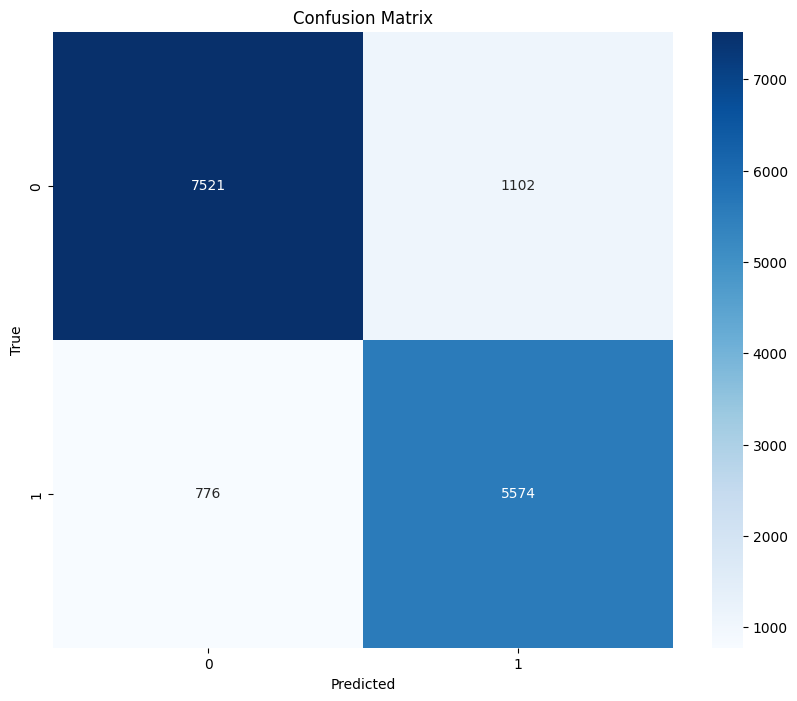

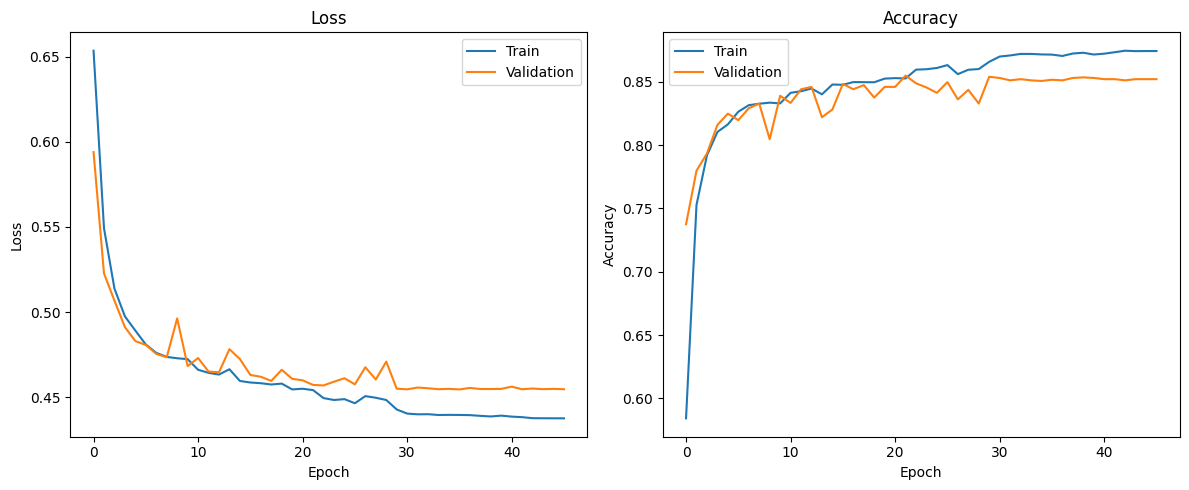

In [18]:
# Threshold 0, multi_label True
train_loader, val_loader, test_loader = perprocessing(*load_data(100, 2, 0, False), label_split=False)
model, history = train_model(CNNClassifier(), train_loader, val_loader, multi_label=True)
accuracy, all_predictions, all_labels = test_model(model, train_loader, multi_label=True)
plot_training_history(history)

['ABNORMAL', 'NORMAL']


Training:  94%|█████████▍| 47/50 [00:28<00:01,  1.66it/s]


Early stopping triggered after epoch 48


Testing: 100%|██████████| 56/56 [00:00<00:00, 243.45it/s]

Test Accuracy: 0.9022

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      7949
           1       0.87      0.91      0.89      6269

    accuracy                           0.90     14218
   macro avg       0.90      0.90      0.90     14218
weighted avg       0.90      0.90      0.90     14218



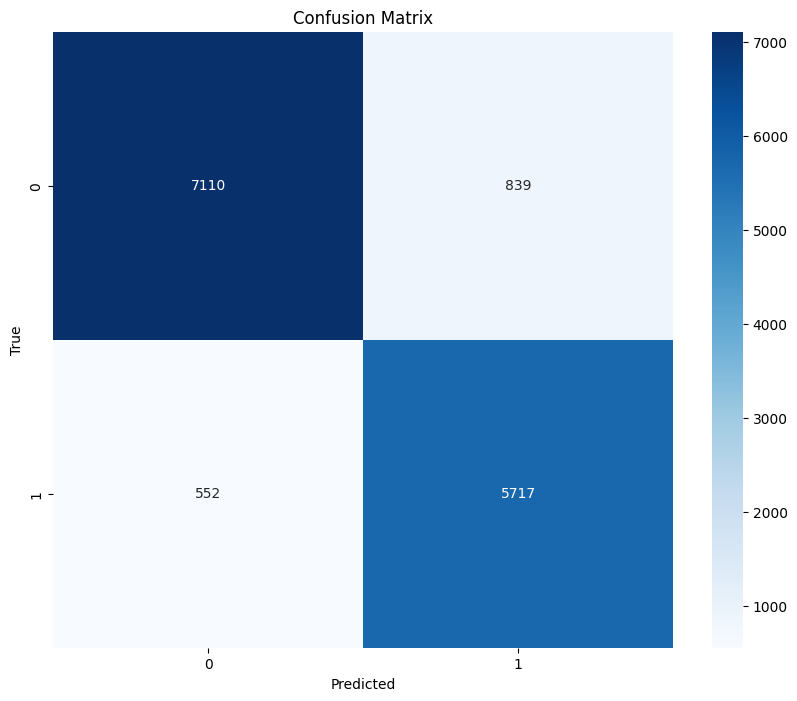

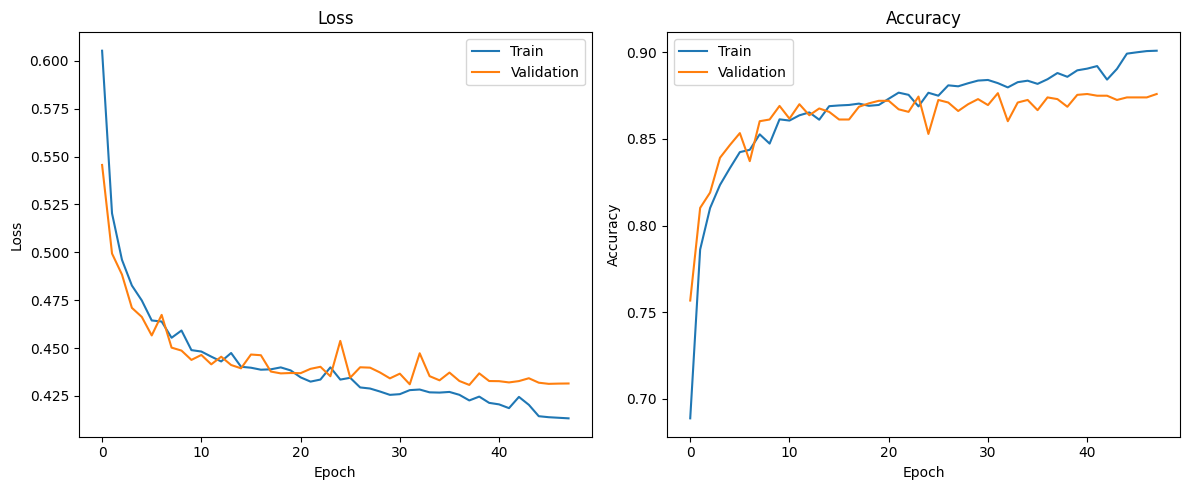

In [19]:
# Threshold 50, multi_label True
train_loader, val_loader, test_loader = perprocessing(*load_data(100, 2, 50, False), label_split=False)
model, history = train_model(CNNClassifier(), train_loader, val_loader, multi_label=True)
accuracy, all_predictions, all_labels = test_model(model, train_loader, multi_label=True)
plot_training_history(history)

['ABNORMAL', 'NORMAL']


Testing: 100%|██████████| 48/48 [00:00<00:00, 193.42it/s]


Test Accuracy: 0.9160

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      7146
           1       0.89      0.90      0.90      4919

    accuracy                           0.92     12065
   macro avg       0.91      0.91      0.91     12065
weighted avg       0.92      0.92      0.92     12065



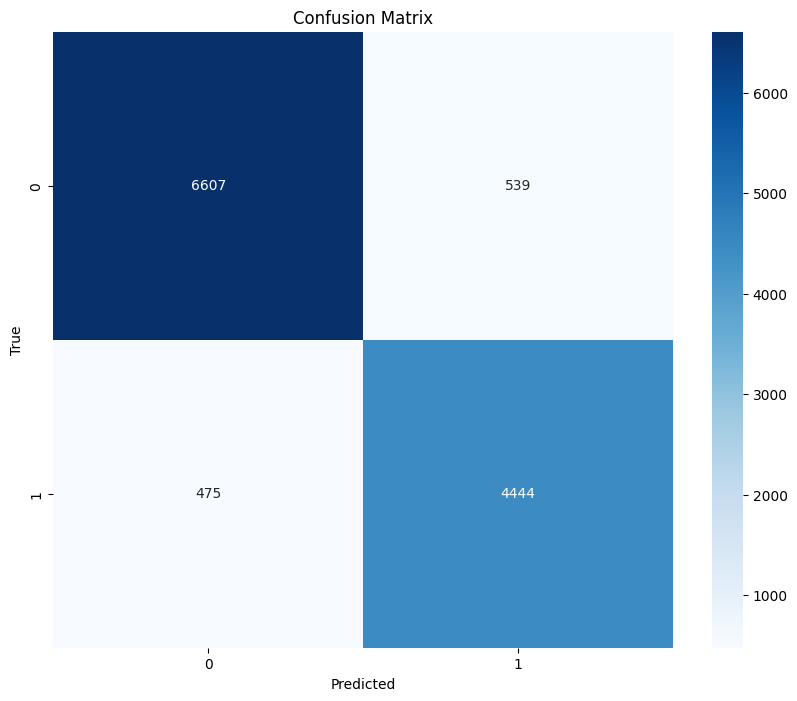

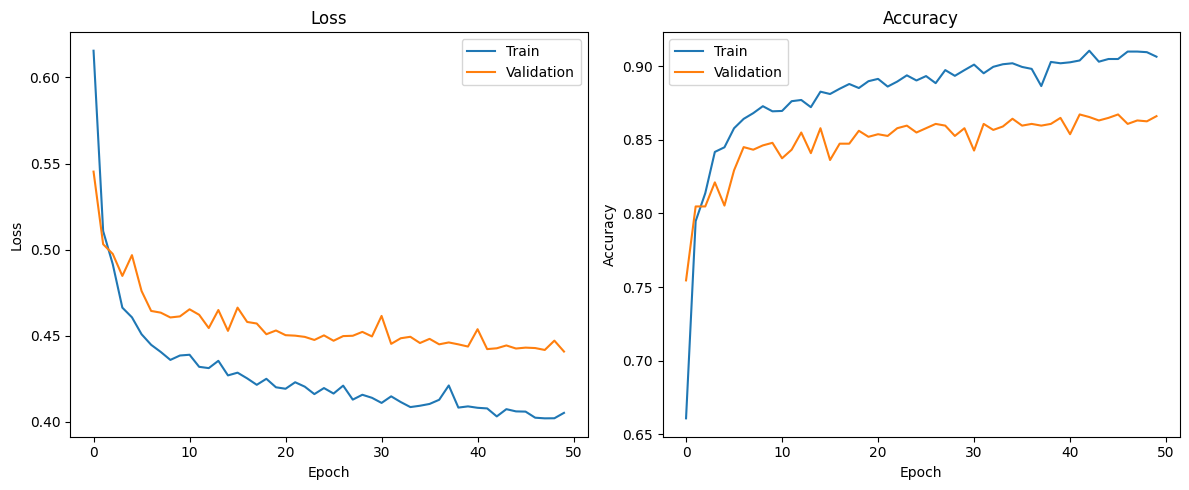

In [20]:
# Threshold 100, multi_label True
train_loader, val_loader, test_loader = perprocessing(*load_data(100, 2,  label_split=False), label_split=False)
model, history = train_model(CNNClassifier(), train_loader, val_loader, multi_label=True)
accuracy, all_predictions, all_labels = test_model(model, train_loader, multi_label=True)
plot_training_history(history)

['ABNORMAL', 'NORMAL']


Training:  76%|███████▌  | 38/50 [00:25<00:07,  1.52it/s]


Early stopping triggered after epoch 39


Testing: 100%|██████████| 60/60 [00:00<00:00, 267.96it/s]

Test Accuracy: 0.8693

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.87      0.89      8934
         1.0       0.83      0.86      0.85      6337

    accuracy                           0.87     15271
   macro avg       0.86      0.87      0.87     15271
weighted avg       0.87      0.87      0.87     15271



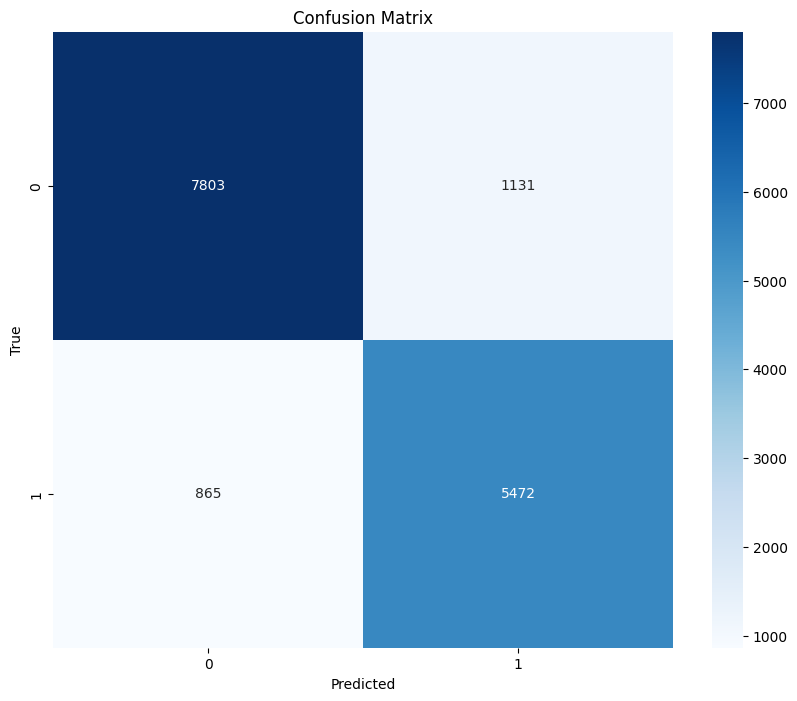

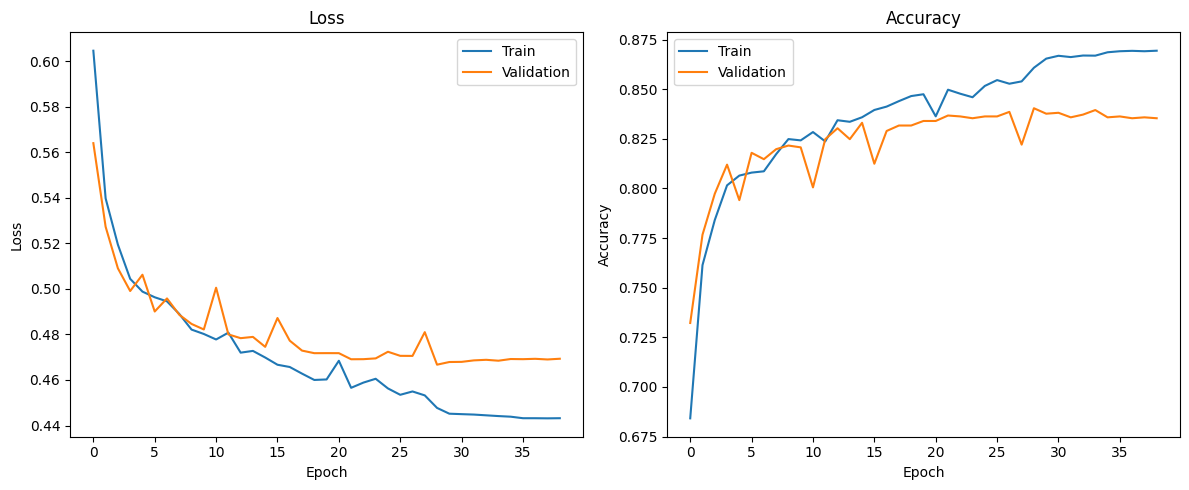

In [21]:
# Threshold 0, multi_label False
train_loader, val_loader, test_loader = perprocessing(*load_data(100, 2, 0))
model, history = train_model(CNNClassifier(), train_loader, val_loader)
accuracy, all_predictions, all_labels = test_model(model, train_loader)
plot_training_history(history)

['ABNORMAL', 'NORMAL']


Testing: 100%|██████████| 57/57 [00:00<00:00, 269.19it/s]

Test Accuracy: 0.8830

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.88      0.89      8198
         1.0       0.85      0.89      0.87      6349

    accuracy                           0.88     14547
   macro avg       0.88      0.88      0.88     14547
weighted avg       0.88      0.88      0.88     14547



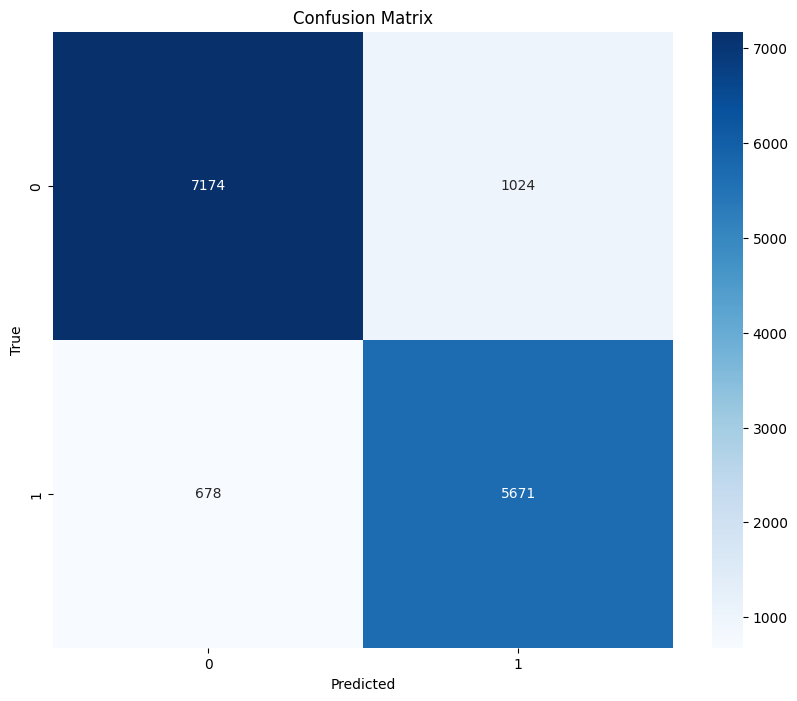

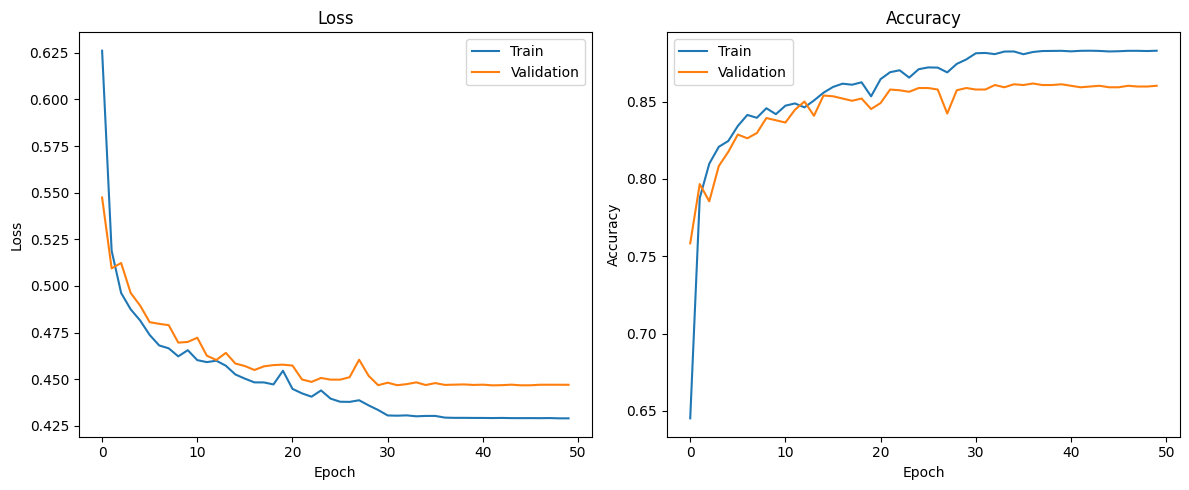

In [22]:
# Threshold 50, multi_label False
train_loader, val_loader, test_loader = perprocessing(*load_data(100, 2, 50))
model, history = train_model(CNNClassifier(), train_loader, val_loader)
accuracy, all_predictions, all_labels = test_model(model, train_loader)
plot_training_history(history)

['ABNORMAL', 'NORMAL']


Training:  82%|████████▏ | 41/50 [00:21<00:04,  1.91it/s]


Early stopping triggered after epoch 42


Testing: 100%|██████████| 48/48 [00:00<00:00, 262.66it/s]

Test Accuracy: 0.9088

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.91      0.92      7252
         1.0       0.87      0.91      0.89      4922

    accuracy                           0.91     12174
   macro avg       0.90      0.91      0.91     12174
weighted avg       0.91      0.91      0.91     12174



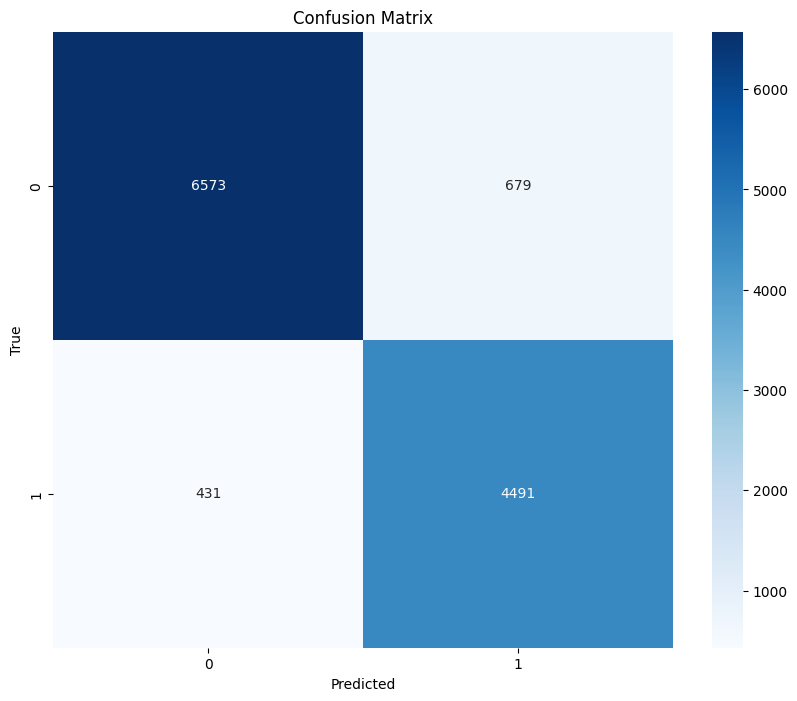

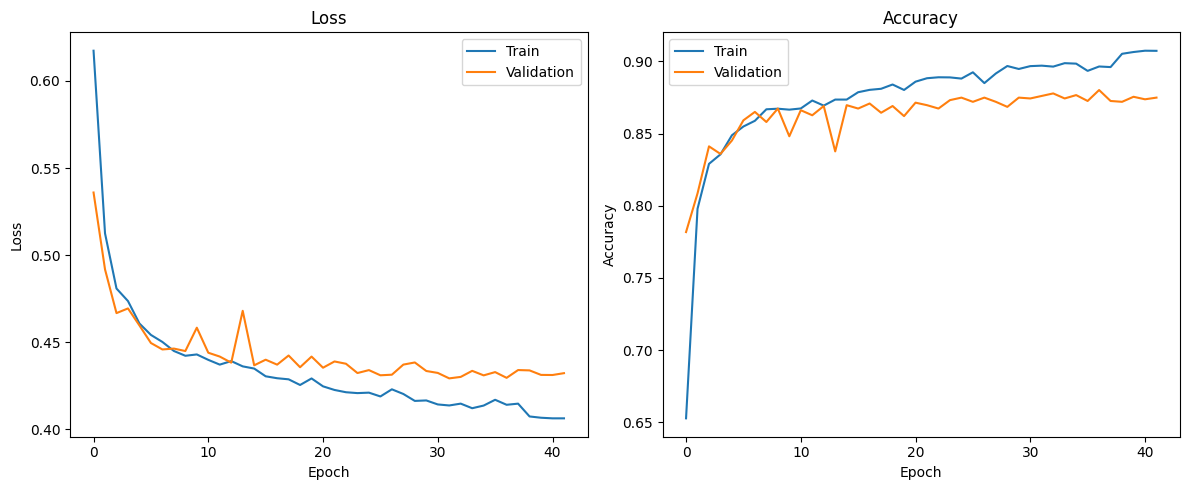

In [23]:
# Threshold 100, multi_label False
train_loader, val_loader, test_loader = perprocessing(*load_data(100, 2))
model, history = train_model(CNNClassifier(), train_loader, val_loader)
accuracy, all_predictions, all_labels = test_model(model, train_loader)
plot_training_history(history)

['ABNORMAL', 'NORMAL']


Testing: 100%|██████████| 48/48 [00:00<00:00, 59.53it/s]


Test Accuracy: 0.8938

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.91      7143
           1       0.84      0.91      0.87      4952

    accuracy                           0.89     12095
   macro avg       0.89      0.90      0.89     12095
weighted avg       0.90      0.89      0.89     12095



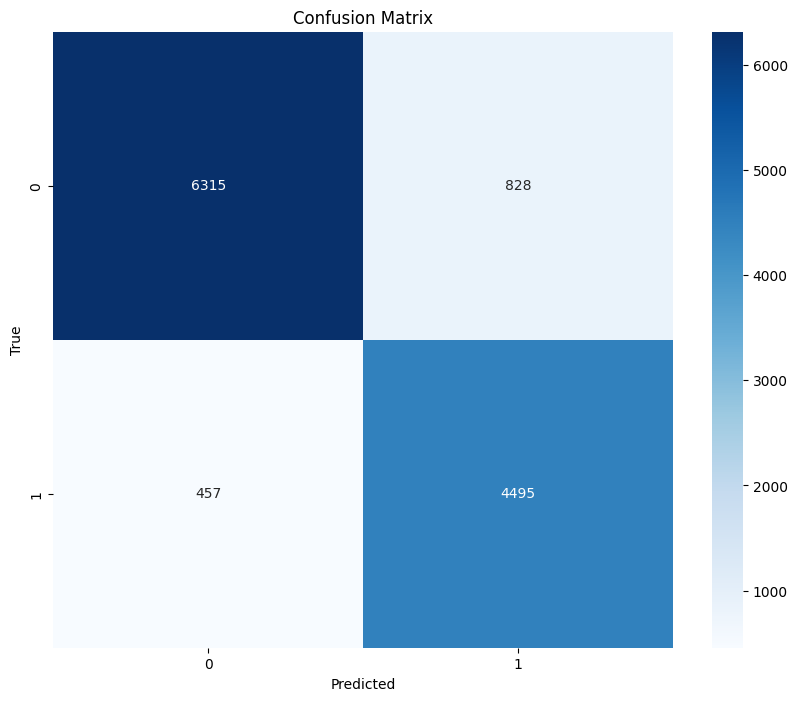

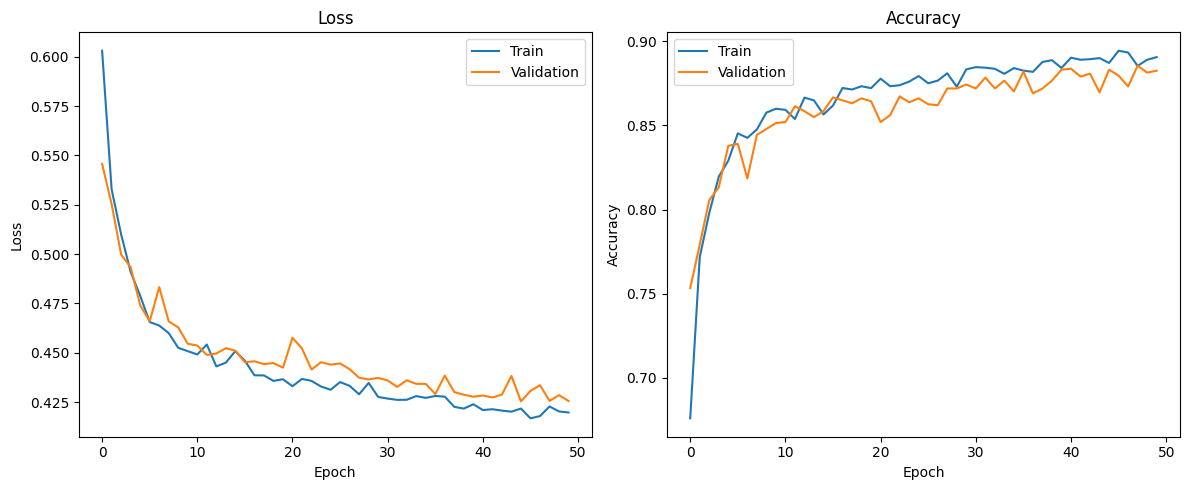

In [24]:
# Threshold 100, multi_label True
train_loader, val_loader, test_loader = perprocessing(*load_data(500, 2,  label_split=False), label_split=False)
model, history = train_model(CNNClassifier(), train_loader, val_loader, multi_label=True)
accuracy, all_predictions, all_labels = test_model(model, train_loader, multi_label=True)
plot_training_history(history)

['ABNORMAL', 'NORMAL']


Testing: 100%|██████████| 48/48 [00:00<00:00, 57.91it/s]


Test Accuracy: 0.8879

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.92      0.91      7193
         1.0       0.88      0.84      0.86      4984

    accuracy                           0.89     12177
   macro avg       0.89      0.88      0.88     12177
weighted avg       0.89      0.89      0.89     12177



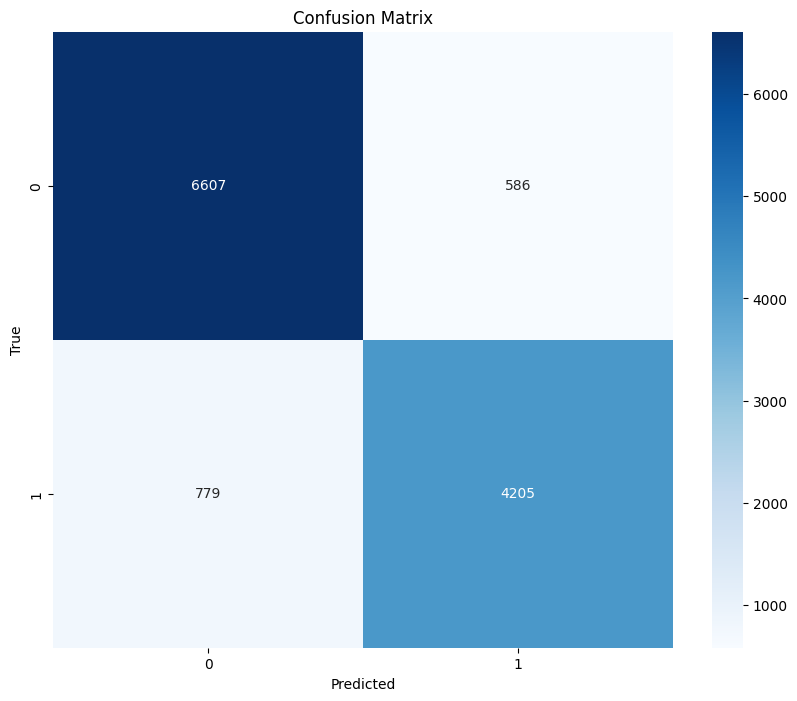

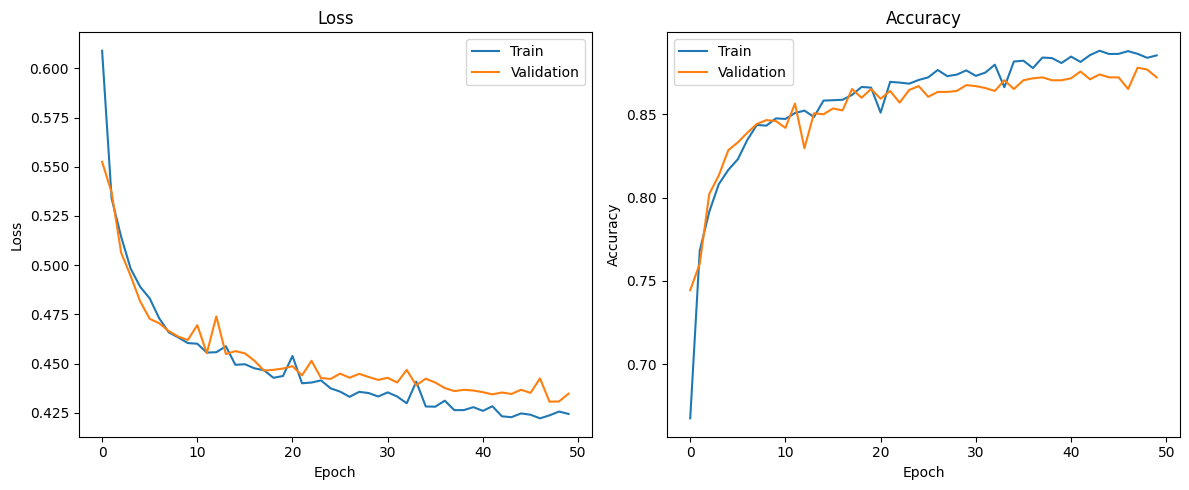

In [25]:
# Threshold 100, multi_label False
train_loader, val_loader, test_loader = perprocessing(*load_data(500, 2))
model, history = train_model(CNNClassifier(), train_loader, val_loader)
accuracy, all_predictions, all_labels = test_model(model, train_loader)
plot_training_history(history)

['CD', 'HYP', 'MI', 'NORM', 'STTC']


Testing: 100%|██████████| 57/57 [00:00<00:00, 251.54it/s]

Test Accuracy: 0.7771

Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.66      0.71      3360
         1.0       0.00      0.00      0.00       146
         2.0       0.76      0.82      0.79      3374
         3.0       0.82      0.93      0.87      5065
         4.0       0.70      0.63      0.66      2638

    accuracy                           0.78     14583
   macro avg       0.61      0.61      0.61     14583
weighted avg       0.77      0.78      0.77     14583




/opt/miniconda3/envs/default/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/default/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/default/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(res

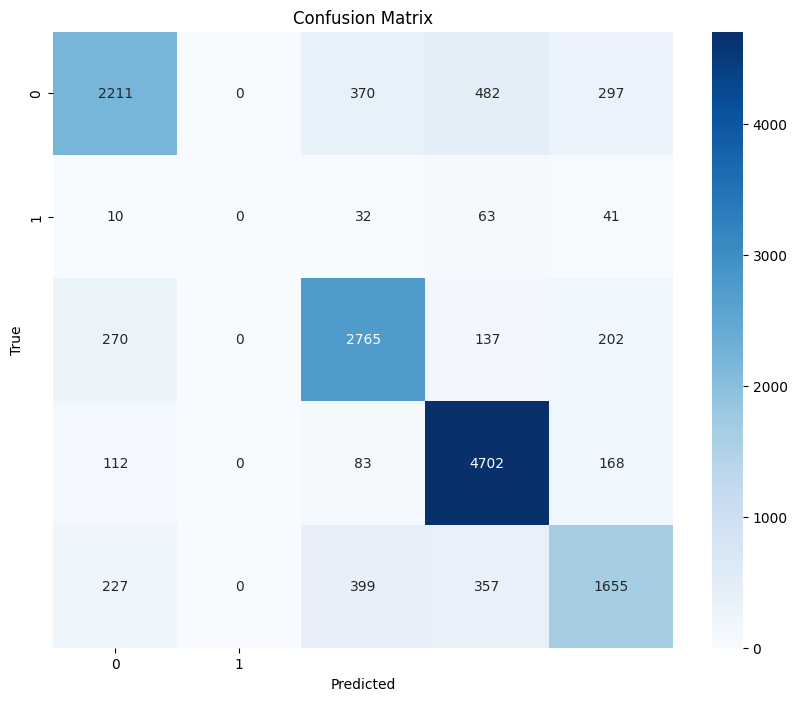

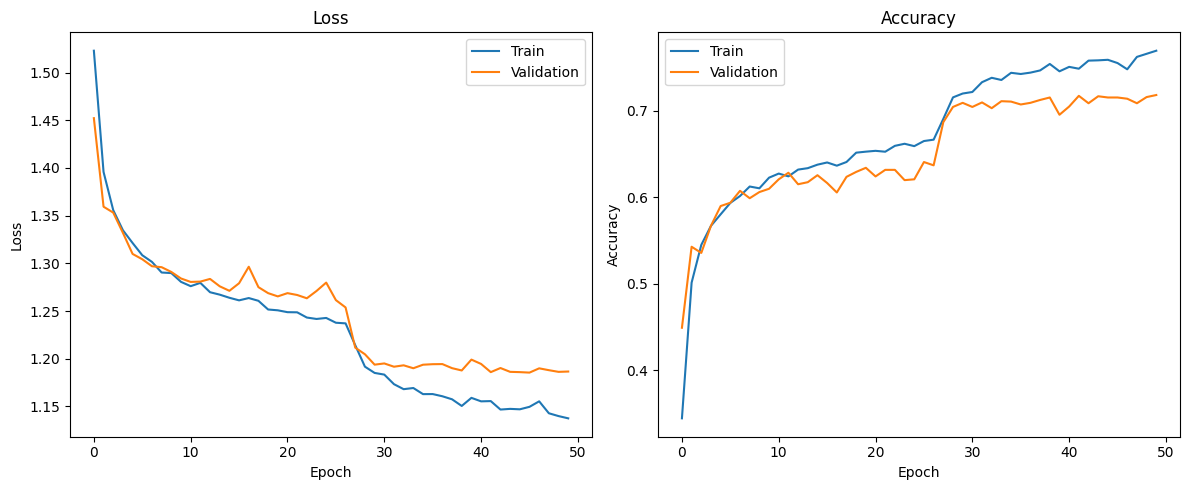

In [26]:
# Threshold 100, multi_label False
train_loader, val_loader, test_loader = perprocessing(*load_data(100, 5))
model, history = train_model(CNNClassifier(num_classes=5), train_loader, val_loader)
accuracy, all_predictions, all_labels = test_model(model, train_loader)
plot_training_history(history)

['AMI', 'CLBBB', 'CRBBB', 'ILBBB', 'IMI', 'IRBBB', 'ISCA', 'ISCI', 'ISC_', 'IVCD', 'LAFB/LPFB', 'LAO/LAE', 'LMI', 'LVH', 'NORM', 'NST_', 'PMI', 'RAO/RAE', 'RVH', 'SEHYP', 'STTC', 'WPW', '_AVB']


Training:  20%|██        | 10/50 [00:07<00:30,  1.32it/s]


Early stopping triggered after epoch 11


Testing: 100%|██████████| 62/62 [00:00<00:00, 254.02it/s]
/opt/miniconda3/envs/default/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/default/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/default/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

Test Accuracy: 0.3177

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1637
         1.0       0.00      0.00      0.00       337
         2.0       0.00      0.00      0.00       576
         3.0       0.00      0.00      0.00        23
         4.0       0.00      0.00      0.00       388
         5.0       0.00      0.00      0.00      1103
         6.0       0.00      0.00      0.00       316
         7.0       0.00      0.00      0.00       303
         8.0       0.00      0.00      0.00      1557
         9.0       0.00      0.00      0.00       275
        10.0       0.00      0.00      0.00       794
        11.0       0.00      0.00      0.00        68
        12.0       0.00      0.00      0.00         7
        13.0       0.00      0.00      0.00       195
        14.0       0.32      1.00      0.48      5014
        15.0       0.00      0.00      0.00       412
        16.0       0.00      0.00  

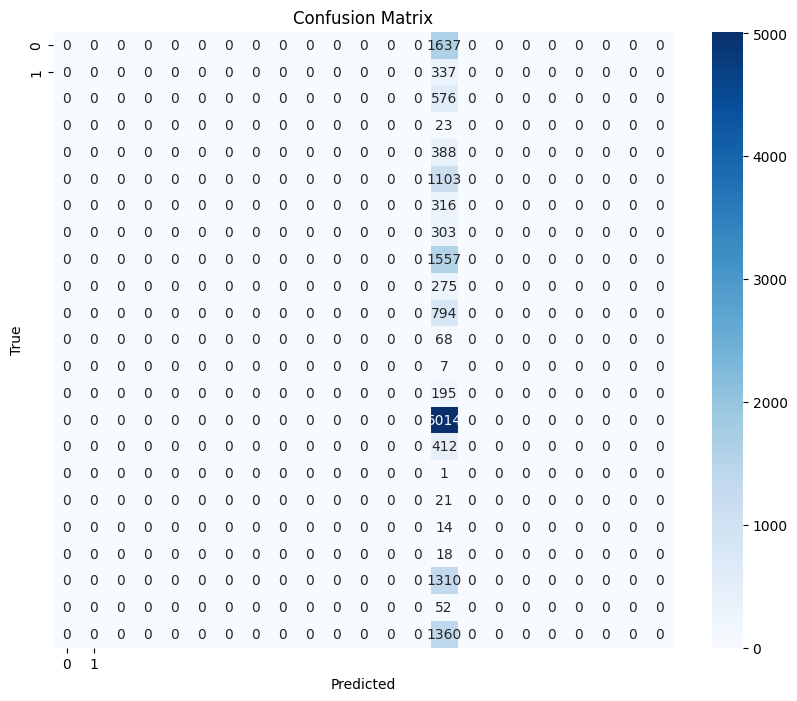

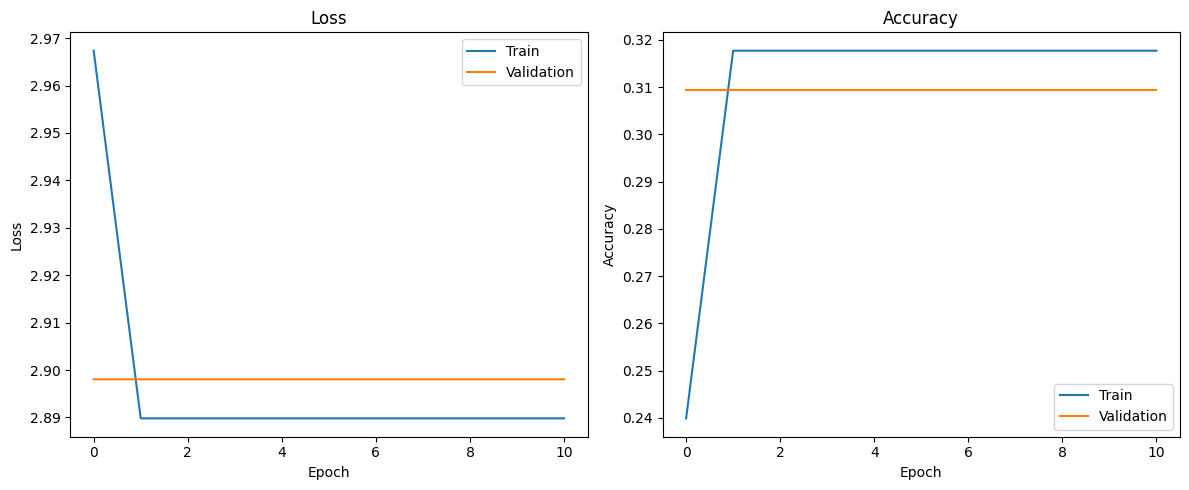

In [27]:
# Threshold 100, multi_label False
train_loader, val_loader, test_loader = perprocessing(*load_data(100, 23))
model, history = train_model(CNNClassifier(num_classes=23), train_loader, val_loader)
accuracy, all_predictions, all_labels = test_model(model, train_loader)
plot_training_history(history)